<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/019_Cross_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔄 Cross-Validation: Prawdziwy Egzamin (K-Fold)

Standardowe podejście do uczenia maszynowego to:
1.  Podziel dane na Trening (80%) i Test (20%).
2.  Naucz model.
3.  Sprawdź wynik.

**Problem:**
A co, jeśli do zbioru testowego trafiły same łatwe przykłady? Twój wynik będzie sztucznie zawyżony.
A co, jeśli trafiły same trudne? Wynik będzie zaniżony.
To jest **Wariancja Losowania**.

**Rozwiązanie: K-Fold Cross-Validation**
1.  Dzielimy dane na K części (np. 5 kawałków tortu).
2.  Trenujemy model 5 razy.
    *   Runda 1: Testujemy na kawałku 1, uczymy na reszcie.
    *   Runda 2: Testujemy na kawałku 2, uczymy na reszcie.
    *   ...
3.  Wyciągamy średnią ze wszystkich rund.

Dopiero ten wynik jest wiarygodny.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 1. ŁADUJEMY DANE
# Użyjemy Drzewa Decyzyjnego, bo one są bardzo wrażliwe na zmianę danych (niestabilne).
iris = load_iris()
X = iris.data
y = iris.target

print("Dane załadowane.")

Dane załadowane.


## Eksperyment 1: Loteria (Zwykły Split)

Zróbmy pętlę, w której 5 razy losujemy podział danych (`train_test_split`) z innym ziarnem losowości (`random_state`).
Zobaczysz, jak bardzo wynik skacze góra-dół.

In [2]:
print("--- METODA STARA (Jeden podział) ---")

for i in range(5):
    # Za każdym razem inne random_state (inne losowanie)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
    
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    wynik = accuracy_score(y_test, model.predict(X_test))
    
    print(f"Próba {i+1}: Accuracy = {wynik*100:.2f}%")

print("\nWniosek: Raz masz 100%, raz 91%. Który wynik jest prawdziwy? Nie wiadomo.")

--- METODA STARA (Jeden podział) ---
Próba 1: Accuracy = 97.78%
Próba 2: Accuracy = 95.56%
Próba 3: Accuracy = 95.56%
Próba 4: Accuracy = 95.56%
Próba 5: Accuracy = 97.78%

Wniosek: Raz masz 100%, raz 91%. Który wynik jest prawdziwy? Nie wiadomo.


## Eksperyment 2: Cross-Validation (K-Fold)

Teraz użyjemy `cross_val_score`.
Podzielimy dane na **5 części (folds)**.
Każdy przykład z danych zostanie użyty dokładnie raz jako test i 4 razy jako trening.

To daje nam **5 niezależnych ocen** tego samego modelu.

In [3]:
# Konfigurujemy K-Fold (5 części, tasujemy dane przed podziałem)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

model = DecisionTreeClassifier()

# Magiczna linijka, która robi wszystko za nas
wyniki = cross_val_score(model, X, y, cv=kfold)

print("--- METODA NOWA (Cross-Validation) ---")
print(f"Wyniki poszczególnych rund: {wyniki}")
print("-" * 30)
print(f"ŚREDNIA DOKŁADNOŚĆ: {wyniki.mean()*100:.2f}%")
print(f"ODCHYLENIE (Niepewność): +/- {wyniki.std()*100:.2f}%")

--- METODA NOWA (Cross-Validation) ---
Wyniki poszczególnych rund: [1.         0.96666667 0.93333333 0.93333333 0.93333333]
------------------------------
ŚREDNIA DOKŁADNOŚĆ: 95.33%
ODCHYLENIE (Niepewność): +/- 2.67%


## Wizualizacja Stabilności

Narysujmy to na wykresie pudełkowym (Boxplot), żeby zobaczyć, jak bardzo nasz model jest "rozchwiany".
Porównamy **Drzewo Decyzyjne** (zwykle niestabilne) z **KNN** (zwykle stabilniejszy).

Drzewo Decyzyjne: Średnia = 0.953, Std = 0.043
KNN (Sąsiedzi): Średnia = 0.967, Std = 0.045


C:\Users\takze\AppData\Local\Temp\ipykernel_24928\1604542938.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results, labels=names)


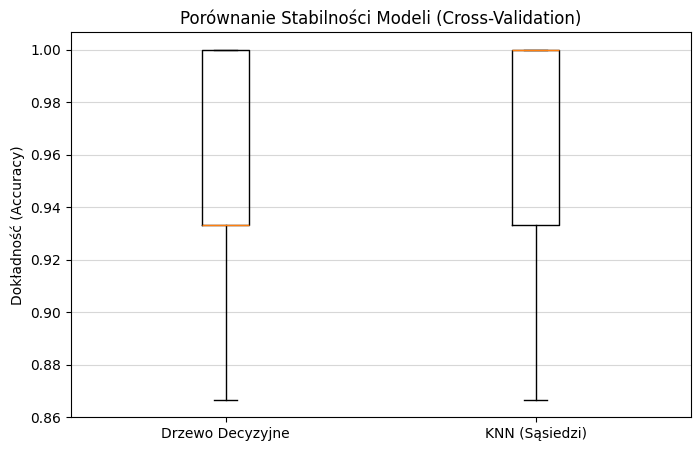

In [4]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

# Porównujemy dwa modele
models = {
    "Drzewo Decyzyjne": DecisionTreeClassifier(),
    "KNN (Sąsiedzi)": KNeighborsClassifier()
}

results = []
names = []

for name, model in models.items():
    # Robimy 10-krotną walidację dla każdego modelu
    cv_results = cross_val_score(model, X, y, cv=10, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print(f"{name}: Średnia = {cv_results.mean():.3f}, Std = {cv_results.std():.3f}")

# Rysujemy
plt.figure(figsize=(8, 5))
plt.boxplot(results, labels=names)
plt.title('Porównanie Stabilności Modeli (Cross-Validation)')
plt.ylabel('Dokładność (Accuracy)')
plt.grid(axis='y', alpha=0.5)
plt.show()

## 🧠 Podsumowanie: Zaufanie to waluta

Dlaczego Cross-Validation jest tak ważna?

**Tu jest haczyk.**
W biznesie nie chodzi o to, żeby mieć najwyższy wynik. Chodzi o to, żeby mieć **przewidywalny** wynik.
*   Jeśli powiesz szefowi: "Model ma 98% skuteczności", a w przyszłym miesiącu spadnie do 85%, stracisz pracę.
*   Jeśli powiesz: "Model ma średnio 94% skuteczności, z odchyleniem +/- 3%", jesteś kryty (bo przewidziałeś spadki).

**Kiedy stosować?**
*   **Zawsze**, gdy masz mały lub średni zbiór danych (< 50 000 wierszy).
*   W Deep Learningu (ogromne zbiory, np. zdjęcia) często się tego unika, bo trening trwa zbyt długo. Tam wracamy do zwykłego podziału Train/Test/Val, ale na ogromnych liczbach statystyka działa na naszą korzyść.